In [10]:
#Set up and Read the data
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer


## **Create Sqlite DB and Load Data into Table**

In [11]:
# read csv file
df_Fact = pd.read_csv('online_retail.csv')

# connect to database
conn = sqlite3.connect("cw")
cur = conn.cursor()

# load CRM data into the cw database
#df_Fact.to_sql("online_retail", conn)
df_Fact.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [12]:
df_Fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## **Data Cleaning Using SQL:**

In [13]:
df_Fact = pd.read_sql("""select * from online_retail 
where InvoiceNo NOT LIKE '%C%'
AND CustomerID IS NOT NULL 
and CustomerID <> ""
AND unitprice != 0 """, conn)
df_Fact.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


## **Distribution Analysis**

/home/geekarea/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/geekarea/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

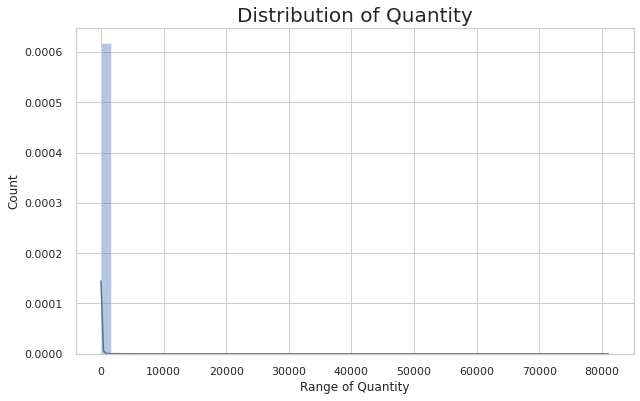

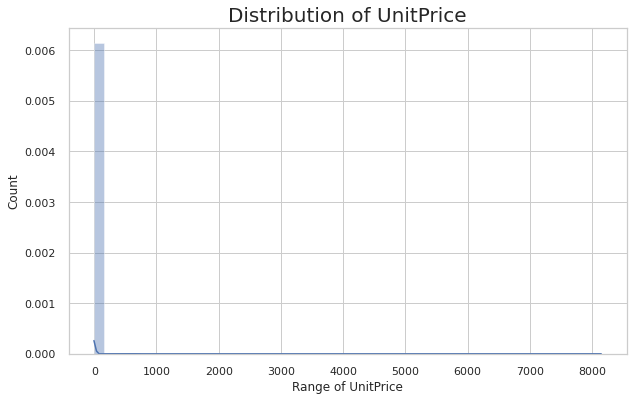

In [14]:

#sns.pairplot(df_Fact.iloc[:, [4,6]])
#Distribution of age
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(df_Fact['Quantity'])
plt.title('Distribution of Quantity', fontsize = 20)
plt.xlabel('Range of Quantity')
plt.ylabel('Count')

#sns.pairplot(df_Fact.iloc[:, [4,6]])
#Distribution of age
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(df_Fact['UnitPrice'])
plt.title('Distribution of UnitPrice', fontsize = 20)
plt.xlabel('Range of UnitPrice')
plt.ylabel('Count')

In [15]:
#sns.displot(df_Fact, x="CustomerID", hue="StockCode", stat="density")

## **Treatment of outliers**

In [16]:

print("Highest allowed UnitPrice:",df_Fact['UnitPrice'].mean() + 3*df_Fact['UnitPrice'].std())
print("Lowest allowed UnitPrice:",df_Fact['UnitPrice'].mean() - 3*df_Fact['UnitPrice'].std())

print("Highest allowed Quantity:",df_Fact['Quantity'].mean() + 3*df_Fact['Quantity'].std())
print("Lowest allowed Quantity:",df_Fact['Quantity'].mean() - 3*df_Fact['Quantity'].std())


Highest allowed UnitPrice: 69.41011764784909
Lowest allowed UnitPrice: -63.17714213740865
Highest allowed Quantity: 550.9835626675814
Lowest allowed Quantity: -525.0070871118918


(397884, 9)
(397275, 9)


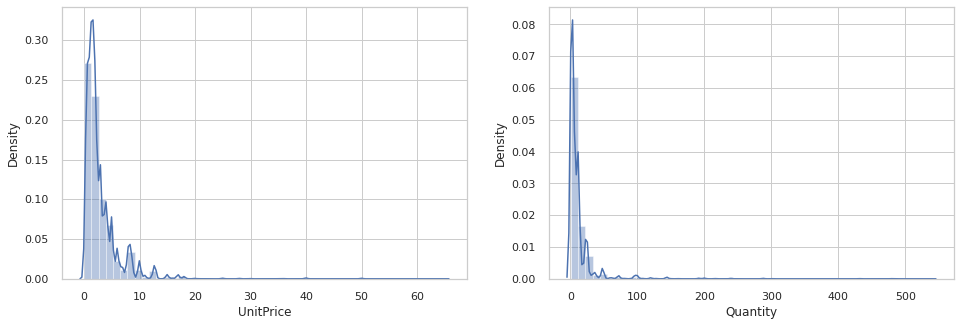

In [17]:
print(df_Fact.shape)
df_Fact = pd.read_sql(""" select * from online_retail where InvoiceNo NOT LIKE '%C%'
AND InvoiceNo NOT LIKE '%C%'
AND CustomerID IS NOT NULL and CustomerID <> ""
AND unitprice != 0 
AND UnitPrice <= 69
AND Quantity <= 550 """, conn)
print(df_Fact.shape)
df_Fact.head()

import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_Fact['UnitPrice'])
plt.subplot(1,2,2)
sns.distplot(df_Fact['Quantity'])
plt.show()

df_Fact = df_Fact

## **Correlation Analysis**

In [18]:
'''
method :
pearson : standard correlation coefficient
kendall : Kendall Tau correlation coefficient
spearman : Spearman rank correlation
'''
df_Fact.corr(method ='pearson')


,index,Quantity,UnitPrice,CustomerID
index,1.000000,-0.017158,-0.035659,0.001263
Quantity,-0.017158,1.000000,-0.157776,-0.043336
UnitPrice,-0.035659,-0.157776,1.000000,-0.037393
CustomerID,0.001263,-0.043336,-0.037393,1.000000


In [19]:
duplicate = df_Fact[df_Fact.duplicated()]
 
print('Duplicate row count:',len(duplicate))

Duplicate row count: 0


## **Data Visualization**

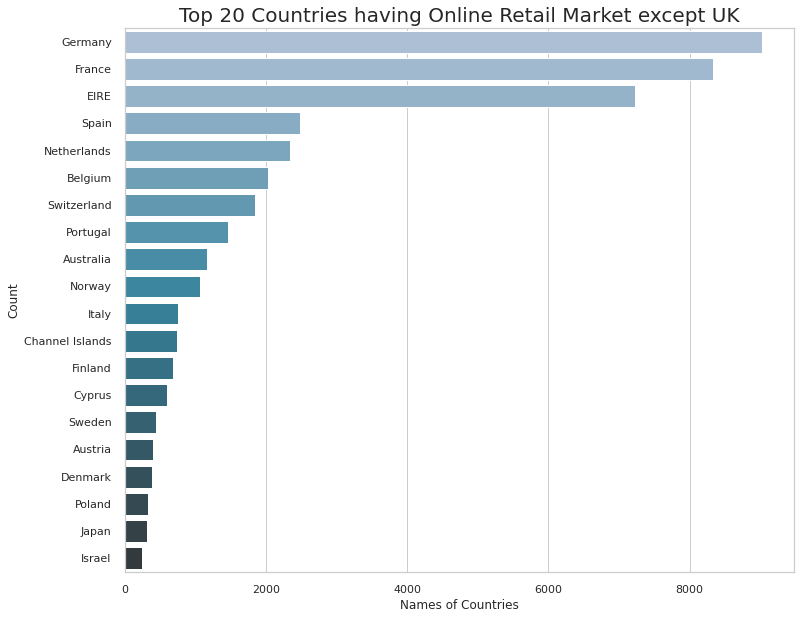

In [20]:
# checking the different values for country in the dataset

plt.rcParams['figure.figsize'] = (12, 10)
a = df_Fact['Country'].value_counts().head(21)[1:]
sns.barplot(x = a.values, y = a.index, palette = 'PuBuGn_d')
plt.title('Top 20 Countries having Online Retail Market except UK', fontsize = 20)
plt.xlabel('Names of Countries')
plt.ylabel('Count')
plt.show()

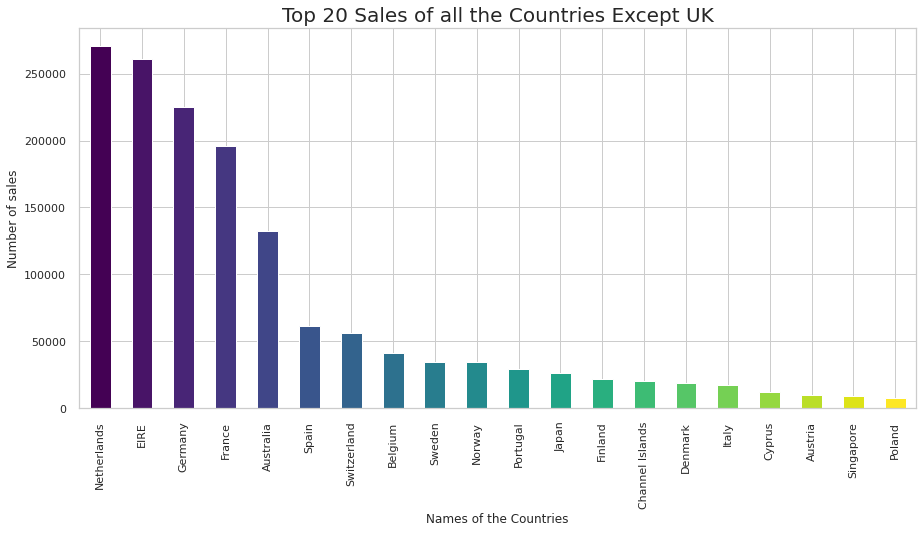

In [21]:
# looking at each country's sales
color = plt.cm.viridis(np.linspace(0, 1, 20))
df_Fact['Sales'] = df_Fact['UnitPrice'] * df_Fact['Quantity']
df_Fact['Sales'].groupby(df_Fact['Country']).agg('sum').sort_values(ascending = False).head(21)[1:].plot.bar(figsize = (15, 7),color = color)
#sns.barplot(x = b.values, y = b.index, palette = 'magma')
plt.title('Top 20 Sales of all the Countries Except UK', fontsize = 20)
plt.xlabel('Names of the Countries')
plt.ylabel('Number of sales')
plt.show()

## **Profile Summary Using Pandas Profiling**

In [ ]:
profile = df_Fact.profile_report(title="Online Retail Data Statistics Report")
profile.to_file(output_file="Online_Retail_Data_Statistics_Report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

## **RFM Segmentation**

In [26]:
# Write clean CRM data into the database

# clean data and group transactions by Customerid
cleandata = pd.read_sql(''' SELECT CustomerID,
MIN(InvoiceDate) AS recent_order_date,
MAX(InvoiceDate) AS last_order_date,
COUNT(*) AS count_order,
SUM(unitprice*quantity) AS totalprice
FROM online_retail
WHERE InvoiceNo NOT LIKE '%C%'
AND CustomerID IS NOT NULL and CustomerID <> ""
AND unitprice != 0 
AND UnitPrice <= 200
AND Quantity <= 600
GROUP BY customerid 
ORDER BY customerid 
''', conn)

cleandata.head()

# Write clean CRM data into the database
cleandata.to_sql("clean_retail_data_8", conn)


## **RFM Segmentation**

In [3]:
#clean the data and calculate rfm values
rmf_df = pd.read_sql(''' 
SELECT customerid,recent_order_date,last_order_date,count_order,totalprice, rfm_recency, rfm_frequency, rfm_monetary,rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined
  FROM
      ( 
		SELECT customerid,recent_order_date,last_order_date, count_order,totalprice,
        NTILE(4) OVER (ORDER BY last_order_date) AS rfm_recency,
        NTILE(4) OVER (ORDER BY count_order) AS rfm_frequency,
        NTILE(4) OVER (ORDER BY totalprice) AS rfm_monetary
        FROM clean_retail_data_7
	)
 ''', conn)

rmf_df.head()

NameError: name 'pd' is not defined

## *Customer Segment based on RFM ScoresCustomer Segment*

In [4]:
def rfm_level(rmf_df):
  if ((rmf_df['rfm_recency'] >= 4) and (rmf_df['rfm_frequency'] >= 4) and (rmf_df['rfm_monetary'] >= 4)):
    return 'Best Customers'
  elif ((rmf_df['rfm_recency'] >= 3) and (rmf_df['rfm_frequency'] >= 3) and (rmf_df['rfm_monetary'] >= 3)):
    return 'Loyal'
  elif ((rmf_df['rfm_recency'] >= 3) and (rmf_df['rfm_frequency'] >= 1) and (rmf_df['rfm_monetary'] >= 2)):
    return 'Potential Loyalist'
  elif ((rmf_df['rfm_recency'] >= 3) and (rmf_df['rfm_frequency'] >= 1) and (rmf_df['rfm_monetary'] >= 1)):
    return 'Promising'
  elif ((rmf_df['rfm_recency'] >= 2) and (rmf_df['rfm_frequency'] >= 2) and (rmf_df['rfm_monetary'] >= 2)):
    return 'Customers Needing Attention'
  elif ((rmf_df['rfm_recency'] >= 1) and (rmf_df['rfm_frequency'] >= 2) and (rmf_df['rfm_monetary'] >= 2)):
    return 'At Risk'
  elif ((rmf_df['rfm_recency'] >= 1) and (rmf_df['rfm_frequency'] >= 1) and (rmf_df['rfm_monetary'] >= 2)):
    return 'Hibernating'
  else:
    return 'Lost'
#Create a new variable rfm_level
rmf_df['rfm_level'] = rmf_df.apply(rfm_level, axis=1)
rmf_df.head()
rmf_df.to_excel(r'./rfm_segmentation_with_level.xlsx', index = False, header=True)

NameError: name 'rmf_df' is not defined

## *Customer Segment wise Customer count*

In [29]:
rfm_agg = rmf_df.groupby('rfm_level').agg({'customerid':'count'})
rfm_agg

,customerid
rfm_level,
At Risk,488
Best Customers,422
Customers Needing Attention,668
Hibernating,219
Lost,787
Loyal,855
Potential Loyalist,591
Promising,294


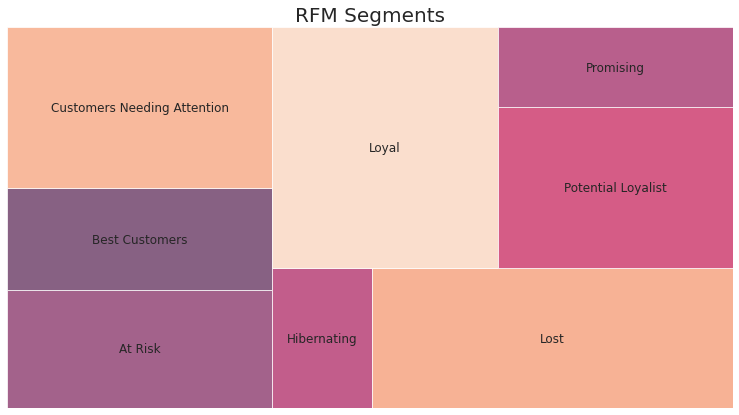

In [30]:
#RFM visualization, you may have to install squarify
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_agg['customerid'],
label=['At Risk','Best Customers','Customers Needing Attention','Hibernating','Lost','Loyal','Potential Loyalist','Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()

In [31]:
rmf_x = rmf_df.iloc[:,3:8]
# Standardizing the features
rmf_x = StandardScaler().fit_transform(rmf_x)
rmf_x

array([[-0.31859377, -0.22068943, -1.34164079, -0.4472136 , -1.34164079],
       [-0.30985815, -0.20185845, -1.34164079, -0.4472136 , -0.4472136 ],
       [-0.32296159, -0.20306977, -1.34164079, -0.4472136 , -0.4472136 ],
       ...,
       [-0.11767438, -0.10881022,  1.34164079,  0.4472136 ,  0.4472136 ],
       [ 0.08324502, -0.00451675,  1.34164079,  1.34164079,  1.34164079],
       [ 2.05312867,  0.62487801,  1.34164079,  1.34164079,  1.34164079]])

In [32]:
pca = PCA()
principalComponents = pca.fit_transform(rmf_x)
principalComponents

print("pca.explained_variance_ratio_:",pca.explained_variance_ratio_)
print("pca.n_components_:",pca.n_components_)

pca.explained_variance_ratio_: [0.50254045 0.20975561 0.13658656 0.10297548 0.0481419 ]
pca.n_components_: 5


In [33]:
# dimension reduction using PCA 
pca_n = PCA(n_components=3)
pca_data = pca_n.fit_transform(rmf_x)
PCA_components = pd.DataFrame(pca_data)
PCA_components.head()

,0,1,2
0,-1.675249,0.676195,-0.584666
1,-1.194857,0.417079,-0.845436
2,-1.200791,0.409716,-0.844389
3,-2.167813,0.905627,-0.239334
4,-1.675729,0.663853,-0.499442


In [123]:
wcss=[]
# fitting multiple k-means algorithms
for i in range(1, 22):
    kmeans = KMeans(n_clusters=i, init='k-means++').fit(pca_data)
    wcss.append(kmeans.inertia_)

print("The inertia of the clusters : ",wcss)

The inertia of the clusters :  [18352.842204666576, 11029.22975720111, 7122.1162911705105, 5478.968052210999, 4232.127745062676, 3517.827559085947, 2878.916628551611, 2430.715066610428, 2030.015549862344, 1827.2084049885987, 1739.5154267160071, 1539.2143173233108, 1448.780607089273, 1273.511469519128, 1150.4739795666164, 1043.5145189239252, 959.461081713722, 879.0104199724922, 824.6340699811998, 751.2631999183816, 681.7565205565472]


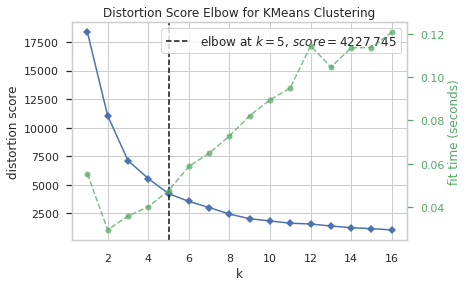

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

<Figure size 432x288 with 0 Axes>

In [124]:
# Elbow method with Yellowbrick Visualiser
visualizer = KElbowVisualizer(kmeans, k=(1,17))
visualizer.fit(pca_data)
visualizer.show()
visualizer.show(outpath="T1_EMG_YB.png")

In [118]:
kmeans = KMeans(n_clusters=5, init ='k-means++')
y_kmeans = kmeans.fit_predict(pca_data)
centers = np.array(kmeans.cluster_centers_)
y_kmeans

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [119]:
#K-means clustering with PCA results
data_pca_kmeans = pd.concat([rmf_df.reset_index(drop=True),pd.DataFrame(pca_data)],axis=1)
data_pca_kmeans.columns.values[-3:] = ["component 1","component 2","component 3"]
data_pca_kmeans["Retail K-means PCA"] = kmeans.labels_
data_pca_kmeans.to_excel (r'./export_dataframe_1.xlsx', index = False, header=True)
data_pca_kmeans.head()

,customerid,recent_order_date,last_order_date,count_order,totalprice,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,component 1,component 2,component 3,Retail K-means PCA
0,17356.0,01/02/11 11:07,01/02/11 11:07,19,178.22,1,2,1,121,Lost,-1.675249,0.676195,-0.584666,1
1,14850.0,01/02/11 11:21,01/02/11 11:21,21,325.75,1,2,2,122,At Risk,-1.194857,0.417079,-0.845436,1
2,13494.0,01/02/11 11:58,01/02/11 11:58,18,316.26,1,2,2,122,At Risk,-1.200791,0.409716,-0.844389,1
3,12929.0,01/02/11 12:08,01/02/11 12:08,8,117.85,1,1,1,111,Lost,-2.167813,0.905627,-0.239334,1
4,12373.0,01/02/11 13:10,01/02/11 13:10,14,364.60,1,1,2,112,Hibernating,-1.675729,0.663853,-0.499442,1


In [120]:
grouped_df = data_pca_kmeans.groupby(["Retail K-means PCA", "rfm_level"]).size()
grouped_df.head()

Retail K-means PCA  rfm_level                  
0                   Best Customers                 411
                    Customers Needing Attention     14
                    Loyal                          675
                    Potential Loyalist              22
1                   At Risk                        202
                    Customers Needing Attention    152
                    Hibernating                    208
                    Lost                           787
2                   Best Customers                  11
                    Customers Needing Attention      1
3                   At Risk                        286
                    Customers Needing Attention    501
                    Hibernating                     11
                    Loyal                          180
                    Potential Loyalist              33
                    Promising                        1
4                   Potential Loyalist             536
                 

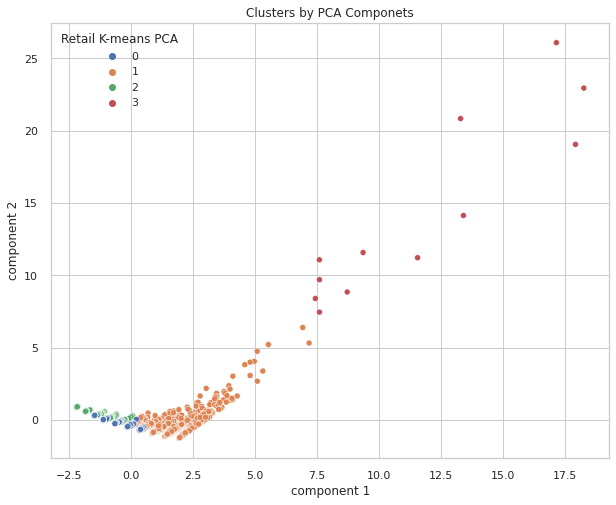

In [116]:
x_axis = data_pca_kmeans["component 1"]
y_axis = data_pca_kmeans["component 2"]
plt.figure(figsize = (10,8))

T=PCA_components.iloc[:,:4]

# store writing xvector yvector columns the values of PCA component in variable: for easy
xvector = pca.components_[0] * max(T[0])
yvector = pca.components_[1] * max(T[1])
columns = rmf_df.columns
    
#print(df_covid_data_pca_kmeans)
#palette =['g','r','c','m','y']
sns.scatterplot(x_axis,y_axis,hue=data_pca_kmeans["Retail K-means PCA"],palette="deep")
plt.title("Clusters by PCA Componets")
plt.show()

In [125]:
# count of points in each of the above-formed clusters
frame = pd.DataFrame(pca_data)
frame['Cluster'] = y_kmeans
frame['Cluster'].value_counts()
frame['Cluster'].value_counts()

1    1349
0    1122
3    1012
4     829
2      12
Name: Cluster, dtype: int64

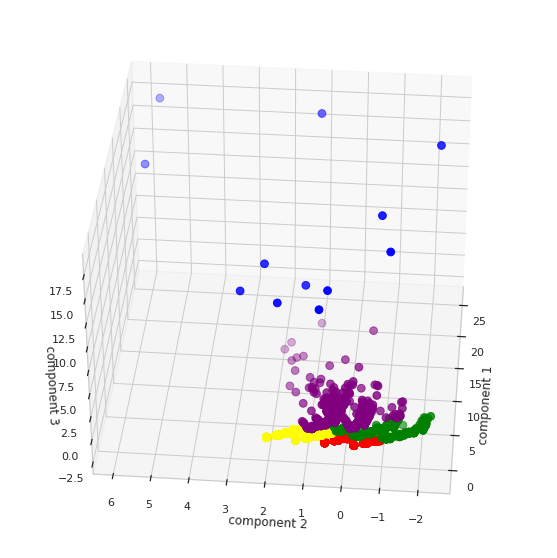

In [122]:
#3D Plot as we did the clustering on the basis of 3 input features
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_kmeans["component 2"][data_pca_kmeans['Retail K-means PCA'] == 0], data_pca_kmeans["component 3"][data_pca_kmeans['Retail K-means PCA']==0],data_pca_kmeans["component 1"][data_pca_kmeans['Retail K-means PCA']==0], c='purple', s=60)
ax.scatter(data_pca_kmeans["component 2"][data_pca_kmeans['Retail K-means PCA'] == 1], data_pca_kmeans["component 3"][data_pca_kmeans['Retail K-means PCA']==1],data_pca_kmeans["component 1"][data_pca_kmeans['Retail K-means PCA']==1], c='red', s=60)
ax.scatter(data_pca_kmeans["component 2"][data_pca_kmeans['Retail K-means PCA'] == 2], data_pca_kmeans["component 3"][data_pca_kmeans['Retail K-means PCA']==2],data_pca_kmeans["component 1"][data_pca_kmeans['Retail K-means PCA']==2], c='blue', s=60)
ax.scatter(data_pca_kmeans["component 2"][data_pca_kmeans['Retail K-means PCA'] == 3], data_pca_kmeans["component 3"][data_pca_kmeans['Retail K-means PCA']==3],data_pca_kmeans["component 1"][data_pca_kmeans['Retail K-means PCA']==3], c='green', s=60)
ax.scatter(data_pca_kmeans["component 2"][data_pca_kmeans['Retail K-means PCA'] == 4], data_pca_kmeans["component 3"][data_pca_kmeans['Retail K-means PCA']==4],data_pca_kmeans["component 1"][data_pca_kmeans['Retail K-means PCA']==4], c='yellow', s=60)
ax.view_init(35, 185)
plt.xlabel("component 1")
plt.ylabel("component 2")
ax.set_zlabel('component 3')
plt.show()